# *(Wang, 2002)* Decision making spiking model

Implementation of the paper: *Wang, Xiao-Jing. "Probabilistic decision making by slow reverberation in cortical circuits." Neuron 36.5 (2002): 955-968.*

- Author : Chaoming Wang (chao.brain@qq.com)

In [1]:
import brainpy as bp
import brainpy.math as bm
import matplotlib.pyplot as plt

bp.__version__

bm.use_backend('jax')

## Neuron model

### LIF neurons

Both pyramidal cells and interneurons are described by leaky integrate-and-fire neurons. 

$$
C_{m} \frac{d V(t)}{d t}=-g_{L}\left(V(t)-V_{L}\right)-I_{s y n}(t)
$$

where 

- $I_{syn}(t)$ represents the total synaptic current flowing into the cell
- resting potential $V_L$ = -70 mV
- firing threshold $V_{th}$ = -50 mV
- reset potential $V_{rest}$ = -55 mV
- membrane capacitance $C_m$ = 0.5 nF for pyramidal cells and 0.2 nF for interneurons
- membrane leak conductance $g_L$ = 25 nS for pyramidal cells and 20 nS for interneurons
- refractory period $\tau_{ref}$ = 2 ms for pyramidal cells and 1 ms for interneurons

In [2]:
class LIF(bp.NeuGroup):
  def __init__(self, size, V_L=-70., V_reset=-55., V_th=-50.,
               Cm=0.5, gL=0.025, t_refractory=2., **kwargs):
    super(LIF, self).__init__(size=size, **kwargs)

    self.V_L = V_L
    self.V_reset = V_reset
    self.V_th = V_th
    self.Cm = Cm
    self.gL = gL
    self.t_refractory = t_refractory

    self.V = bm.Variable(bm.ones(self.num) * V_L)
    self.input = bm.Variable(bm.zeros(self.num))
    self.spike = bm.Variable(bm.zeros(self.num, dtype=bool))
    self.refractory = bm.Variable(bm.zeros(self.num, dtype=bool))
    self.t_last_spike = bm.Variable(bm.ones(self.num) * -1e7)

  @bp.odeint
  def integral(self, V, t, Iext):
    dVdt = (- self.gL * (V - self.V_L) - Iext) / self.Cm
    return dVdt

  def update(self, _t, _dt):
    ref = (_t - self.t_last_spike) <= self.t_refractory
    V = self.integral(self.V, _t, self.input)
    V = bm.where(ref, self.V, V)
    spike = (V >= self.V_th)
    self.V[:] = bm.where(spike, self.V_reset, V)
    self.spike[:] = spike
    self.t_last_spike[:] = bm.where(spike, _t, self.t_last_spike)
    self.refractory[:] = bm.logical_or(spike, ref)
    self.input[:] = 0.

### Poisson neurons

In [3]:
class PoissonNoise(bp.NeuGroup):
  def __init__(self, size, freq, **kwargs):
    super(PoissonNoise, self).__init__(size=size, **kwargs)

    self.freq = bm.Variable(bm.array([freq]))
    self.dt = bm.get_dt() / 1000.
    self.spike = bm.Variable(bm.zeros(self.num, dtype=bool))
    self.rng = bm.random.RandomState()

  def update(self, _t, _dt):
    self.spike[:] = self.rng.random(self.num) < self.freq[0] * self.dt

## Synapse models

The total synaptic currents are given by

$$
I_{s y n}(t)=I_{e x t, A M P A}(t)+I_{r e c, A M P A}(t)+I_{r e c, N M D A}(t)+I_{r e c, G A B A}(t)
$$

in which

$$
\begin{gathered}
I_{\mathrm{ext}, \mathrm{AMPA}}(t)=g_{\mathrm{ext}, \mathrm{AMPA}}\left(V(t)-V_{E}\right) \mathrm{s}^{\mathrm{ext}, \mathrm{AMPA}}(t) \\
I_{\mathrm{rec}, \mathrm{AMPA}}(t)=g_{\mathrm{rec}, \mathrm{AMPA}}\left(V(t)-V_{E}\right) \sum_{\mathrm{j}=1}^{\mathrm{C}_{\mathrm{E}}} W_{j} S_{j}^{\mathrm{AMPA}}(t) \\
I_{\mathrm{rec}, \mathrm{NMDA}}(t)=\frac{g_{\mathrm{NMDA}}\left(V(t)-V_{E}\right)}{\left(1+\left[\mathrm{Mg}^{2+}\right] \exp (-0.062 V(t)) / 3.57\right)} \sum_{j=1}^{\mathrm{c}_{E}} w_{j} \mathrm{~s}_{j}^{\mathrm{NMDA}}(t) \\
I_{\mathrm{rec}, \mathrm{GABA}}(t)=g_{\mathrm{GABA}}\left(V(t)-V_{l}\right) \sum_{j=1}^{c_{1}} s_{j}^{\mathrm{GABA}}(t)
\end{gathered}
$$

where 

- $V_E$ = 0 mV
- $V_I$ = -70 mV 
- $\left[\mathrm{Mg}^{2+}\right]$ = 1 mM
- The dimensionless weights $w_j$ represent the structured excitatory recurrent connections
- the sum over $j$ represents a sum over the synapses formed by presynaptic neurons $j$

### AMPA

The AMPA (external and recurrent) channels are described by

$$
\frac{d s_{j}^{A M P A}(t)}{d t}=-\frac{s_{j}^{A M P A}(t)}{\tau_{A M P A}}+\sum_{k} \delta\left(t-t_{j}^{k}\right)
$$

where 

- the decay time of AMPA currents $\tau_{A M P A}$ = 2 ms
- for the external AMPA currents, the spikes are emitted according to a Poisson process with rate $V_{ext}$ = 2400 Hz independently from cell to cell

In [4]:
class AMPA_One(bp.TwoEndConn):
  def __init__(self, pre, post, delay=0.5, g_max=0.10, E=0., tau=2.0, **kwargs):
    super(AMPA_One, self).__init__(pre=pre, post=post, **kwargs)

    # parameters
    self.g_max = g_max
    self.E = E
    self.tau = tau
    self.delay = delay

    # variables
    self.pre_spike = self.register_constant_delay('ps', size=self.pre.num, delay=delay)
    self.s = bm.Variable(bm.zeros(self.pre.num))

  @bp.odeint
  def int_s(self, s, t):
    ds = - s / self.tau
    return ds

  def update(self, _t, _dt):
    self.pre_spike.push(self.pre.spike)
    pre_spike = self.pre_spike.pull()
    self.s[:] = self.int_s(self.s, _t)
    self.s += pre_spike * self.g_max
    self.post.input += self.s * (self.post.V - self.E)

In [5]:
class AMPA(bp.TwoEndConn):
  def __init__(self, pre, post, delay=0.5, g_max=0.10, E=0., tau=2.0, **kwargs):
    super(AMPA, self).__init__(pre=pre, post=post, **kwargs)

    # parameters
    self.g_max = g_max
    self.E = E
    self.tau = tau
    self.delay = delay
    self.size = (self.pre.num, self.post.num)

    # variables
    self.pre_spike = self.register_constant_delay('ps', size=self.pre.num, delay=delay)
    self.pre_one = bm.Variable(bm.ones(self.pre.num))
    self.s = bm.Variable(bm.zeros(self.size))

  @bp.odeint
  def int_s(self, s, t):
    ds = - s / self.tau
    return ds

  def update(self, _t, _dt):
    self.pre_spike.push(self.pre.spike)
    pre_spike = self.pre_spike.pull()
    self.s[:] = self.int_s(self.s, _t)
    self.s += (pre_spike * self.g_max).reshape((-1, 1))
    self.post.input += bm.dot(self.pre_one, self.s) * (self.post.V - self.E)

### NMDA

NMDA channels are described by:

$$
\begin{gathered}
\frac{d s_{j}^{\mathrm{NMDA}}(t)}{d t}=-\frac{s_{j}^{\mathrm{NMDA}}(t)}{\tau_{\mathrm{NMDA}, \text { decay }}}+\alpha x_{j}(t)\left(1-s_{j}^{\mathrm{NMDA}}(t)\right) \\
\frac{d x_{j}(t)}{d t}=-\frac{x_{j}(t)}{\tau_{\mathrm{NMDA}, \text { rise }}}+\sum_{k} \delta\left(t-t_{j}^{k}\right)
\end{gathered}
$$

where

- the decay time $\tau_{\mathrm{NMDA}, \text { decay }}$ = 100 ms
- $\alpha$ = 0.5 $\mathrm{ms}^{-1}$
- the rise time $\tau_{\mathrm{NMDA}, \text { rise }}$ = 2 ms

In [6]:
class NMDA(bp.TwoEndConn):
  def __init__(self, pre, post, delay=0.5, tau_decay=100, tau_rise=2.,
               g_max=0.15, E=0., cc_Mg=1., alpha=0.5, **kwargs):
    super(NMDA, self).__init__(pre=pre, post=post, **kwargs)

    # parameters
    self.g_max = g_max
    self.E = E
    self.cc_Mg = cc_Mg
    self.alpha = alpha
    self.tau_decay = tau_decay
    self.tau_rise = tau_rise
    self.delay = delay
    self.size = (self.pre.num, self.post.num)

    # variables
    self.pre_spike = self.register_constant_delay('ps', size=self.pre.num, delay=delay)
    self.pre_one = bm.Variable(bm.ones(self.pre.num))
    self.s = bm.Variable(bm.zeros(self.size))
    self.x = bm.Variable(bm.zeros(self.size))

  @bp.odeint
  def integral(self, s, x, t):
    dsdt = -s / self.tau_decay + self.alpha * x * (1 - s)
    dxdt = -x / self.tau_rise
    return dsdt, dxdt

  def update(self, _t, _dt):
    self.pre_spike.push(self.pre.spike)
    pre_spike = self.pre_spike.pull()
    self.s[:], self.x[:] = self.integral(self.s, self.x, _t)
    self.x += pre_spike.reshape((-1, 1))
    g_inf = 1 / (1 + self.cc_Mg * bm.exp(-0.062 * self.post.V) / 3.57)
    Iext = bm.dot(self.pre_one, self.s) * (self.post.V - self.E) * g_inf
    self.post.input += Iext * self.g_max

### GABAA

The GABA synaptic variable obeys

$$
\frac{d s_{j}^{G A B A}(t)}{d t}=-\frac{s_{j}^{G A B A}(t)}{\tau_{G A B A}}+\sum_{k} \delta\left(t-t_{j}^{k}\right)
$$

where
- the decay time of AMPA currents $\tau_{GABA}$ = 5 ms

In [7]:
class GABAa(AMPA):
  def __init__(self, pre, post, delay=0.5, g_max=0.10, E=-70., tau=5.0, **kwargs):
    super(GABAa, self).__init__(pre=pre, post=post, E=E, tau=tau, delay=delay, g_max=g_max, **kwargs)

## Parameters

In [8]:
scale = 1.
num_exc = int(1600 * scale)
num_inh = int(400 * scale)
f = 0.15
num_A = int(f * num_exc)
num_B = int(f * num_exc)
num_N = num_exc - num_A - num_B
print(f'Total network size: {num_exc + num_inh}')

Total network size: 2000


In [9]:
mu0 = 40.
coherence = 25.6

In [10]:
# times
pre_period = 100.
stim_period = 1000.
delay_period = 500.
total_period = pre_period + stim_period + delay_period

In [11]:
poisson_freq = 2400.  # Hz
w_pos = 1.7
w_neg = 1. - f * (w_pos - 1.) / (1. - f)
g_max_ext2E_AMPA = 2.1 * 1e-3  # uS
g_max_ext2I_AMPA = 1.62 * 1e-3  # uS
g_max_E2E_AMPA = 0.05 * 1e-3 / scale  # uS
g_max_E2E_NMDA = 0.165 * 1e-3 / scale  # uS
g_max_E2I_AMPA = 0.04 * 1e-3 / scale  # uS
g_max_E2I_NMDA = 0.13 * 1e-3 / scale  # uS
g_max_I2E_GABAa = 1.3 * 1e-3 / scale  # uS
g_max_I2I_GABAa = 1.0 * 1e-3 / scale  # uS

## Build the network

In [12]:
# E neurons/pyramid neurons
A = LIF(num_A, Cm=0.5, gL=0.025, t_refractory=2.)
B = LIF(num_B, Cm=0.5, gL=0.025, t_refractory=2.)
N = LIF(num_N, Cm=0.5, gL=0.025, t_refractory=2.)
# I neurons/interneurons
I = LIF(num_inh, Cm=0.2, gL=0.020, t_refractory=1.)

In [13]:
IA = PoissonNoise(num_A, freq=mu0 + mu0 / 100. * coherence)
IA.freq_mean = mu0 + mu0 / 100. * coherence
IA.freq_var = 10.
IA.t_interval = 50.
IA.t_last_change = -1e7

IB = PoissonNoise(num_B, freq=mu0 - mu0 / 100. * coherence)
IB.freq_mean = mu0 - mu0 / 100. * coherence
IB.freq_var = 10.
IB.t_interval = 50.
IB.t_last_change = -1e7

In [14]:
noise_A = PoissonNoise(num_A, freq=poisson_freq)
noise_B = PoissonNoise(num_B, freq=poisson_freq)
noise_N = PoissonNoise(num_N, freq=poisson_freq)
noise_I = PoissonNoise(num_inh, freq=poisson_freq)

In [15]:
IA2A = AMPA_One(pre=IA, post=A, g_max=g_max_ext2E_AMPA)
IB2B = AMPA_One(pre=IB, post=B, g_max=g_max_ext2E_AMPA)

In [16]:
## define E2E conn
A2A_AMPA = AMPA(pre=A, post=A, g_max=g_max_E2E_AMPA * w_pos)
A2A_NMDA = NMDA(pre=A, post=A, g_max=g_max_E2E_NMDA * w_pos)

A2B_AMPA = AMPA(pre=A, post=B, g_max=g_max_E2E_AMPA * w_neg)
A2B_NMDA = NMDA(pre=A, post=B, g_max=g_max_E2E_NMDA * w_neg)

A2N_AMPA = AMPA(pre=A, post=N, g_max=g_max_E2E_AMPA)
A2N_NMDA = NMDA(pre=A, post=N, g_max=g_max_E2E_NMDA)

B2A_AMPA = AMPA(pre=B, post=A, g_max=g_max_E2E_AMPA * w_neg)
B2A_NMDA = NMDA(pre=B, post=A, g_max=g_max_E2E_NMDA * w_neg)

B2B_AMPA = AMPA(pre=B, post=B, g_max=g_max_E2E_AMPA * w_pos)
B2B_NMDA = NMDA(pre=B, post=B, g_max=g_max_E2E_NMDA * w_pos)

B2N_AMPA = AMPA(pre=B, post=N, g_max=g_max_E2E_AMPA)
B2N_NMDA = NMDA(pre=B, post=N, g_max=g_max_E2E_NMDA)

N2A_AMPA = AMPA(pre=N, post=A, g_max=g_max_E2E_AMPA * w_neg)
N2A_NMDA = NMDA(pre=N, post=A, g_max=g_max_E2E_NMDA * w_neg)

N2B_AMPA = AMPA(pre=N, post=B, g_max=g_max_E2E_AMPA * w_neg)
N2B_NMDA = NMDA(pre=N, post=B, g_max=g_max_E2E_NMDA * w_neg)

N2N_AMPA = AMPA(pre=N, post=N, g_max=g_max_E2E_AMPA)
N2N_NMDA = NMDA(pre=N, post=N, g_max=g_max_E2E_NMDA)

## define E2I conn
A2I_AMPA = AMPA(pre=A, post=I, g_max=g_max_E2I_AMPA)
A2I_NMDA = NMDA(pre=A, post=I, g_max=g_max_E2I_NMDA)

B2I_AMPA = AMPA(pre=B, post=I, g_max=g_max_E2I_AMPA)
B2I_NMDA = NMDA(pre=B, post=I, g_max=g_max_E2I_NMDA)

N2I_AMPA = AMPA(pre=N, post=I, g_max=g_max_E2I_AMPA)
N2I_NMDA = NMDA(pre=N, post=I, g_max=g_max_E2I_NMDA)

I2A_GABAa = GABAa(pre=I, post=A, g_max=g_max_I2E_GABAa)
I2B_GABAa = GABAa(pre=I, post=B, g_max=g_max_I2E_GABAa)
I2N_GABAa = GABAa(pre=I, post=N, g_max=g_max_I2E_GABAa)

## define I2I conn
I2I_GABAa = GABAa(pre=I, post=I, g_max=g_max_I2I_GABAa)

## define external projections
noise2A = AMPA_One(pre=noise_A, post=A, g_max=g_max_ext2E_AMPA)
noise2B = AMPA_One(pre=noise_B, post=B, g_max=g_max_ext2E_AMPA)
noise2N = AMPA_One(pre=noise_N, post=N, g_max=g_max_ext2E_AMPA)
noise2I = AMPA_One(pre=noise_I, post=I, g_max=g_max_ext2I_AMPA)

In [17]:
# build & simulate network
net = bp.Network(
  # Synaptic Connections
  noise2A, noise2B, noise2N, noise2I, IA2A, IB2B,
  A2A_AMPA, A2A_NMDA, A2B_AMPA, A2B_NMDA, A2N_AMPA, A2N_NMDA, B2A_AMPA, B2A_NMDA,
  B2B_AMPA, B2B_NMDA, B2N_AMPA, B2N_NMDA, N2A_AMPA, N2A_NMDA, N2B_AMPA, N2B_NMDA,
  A2I_AMPA, A2I_NMDA, B2I_AMPA, B2I_NMDA, N2I_AMPA, N2I_NMDA, N2N_AMPA, N2N_NMDA,
  I2A_GABAa, I2B_GABAa, I2N_GABAa, I2I_GABAa,
  # Neuron Groups
  noise_A, noise_B, noise_N, noise_I, N, I,
  A=A, B=B, IA=IA, IB=IB,
  monitors=['A.spike', 'B.spike', 'IA.freq', 'IB.freq']
)
net = bm.jit(net)

In [18]:
def change_poisson_freq(_t, _dt):
  for group in [IA, IB]:
    if pre_period < _t < pre_period + stim_period:
      if (_t - group.t_last_change) >= group.t_interval:
        group.freq[0] = bm.random.normal(group.freq_mean, group.freq_var)
        group.t_last_change = _t
    else:
      group.freq[0] = 0.

In [19]:
net.run(duration=total_period, report=0.1, extra_func=change_poisson_freq)

Compilation used 7.1072 s.
Start running ...
Run 10.0% used 22.470 s.
Run 20.0% used 43.390 s.
Run 30.0% used 64.314 s.
Run 40.0% used 85.112 s.
Run 50.0% used 105.721 s.
Run 60.0% used 126.393 s.
Run 70.0% used 147.367 s.
Run 80.0% used 170.041 s.
Run 90.0% used 192.863 s.
Run 100.0% used 215.638 s.
Simulation is done in 215.638 s.



215.63795399665833

## Visualization

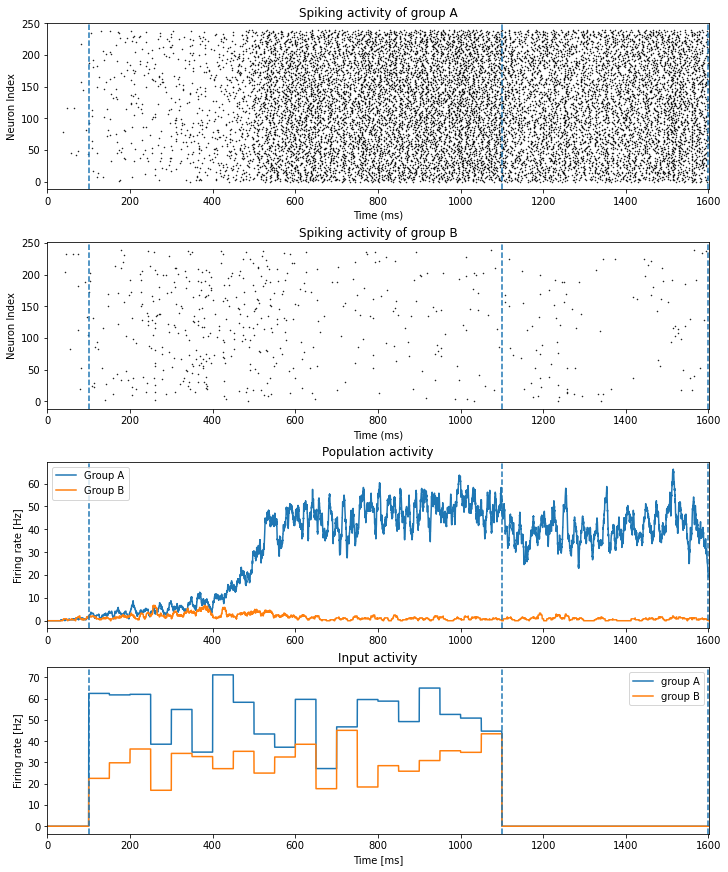

In [20]:
fig, gs = bp.visualize.get_figure(4, 1, 3, 10)

t_start = 0.
fig.add_subplot(gs[0, 0])
bp.visualize.raster_plot(net.mon.ts, net.mon['A.spike'], markersize=1)
plt.title("Spiking activity of group A")
plt.ylabel("Neuron Index")
plt.xlim(t_start, total_period + 1)
plt.axvline(pre_period, linestyle='dashed')
plt.axvline(pre_period + stim_period, linestyle='dashed')
plt.axvline(pre_period + stim_period + delay_period, linestyle='dashed')

fig.add_subplot(gs[1, 0])
bp.visualize.raster_plot(net.mon.ts, net.mon['B.spike'], markersize=1)
plt.title("Spiking activity of group B")
plt.ylabel("Neuron Index")
plt.xlim(t_start, total_period + 1)
plt.axvline(pre_period, linestyle='dashed')
plt.axvline(pre_period + stim_period, linestyle='dashed')
plt.axvline(pre_period + stim_period + delay_period, linestyle='dashed')

fig.add_subplot(gs[2, 0])
rateA = bp.measure.firing_rate(net.mon['A.spike'], width=10.)
rateB = bp.measure.firing_rate(net.mon['B.spike'], width=10.)
plt.plot(net.mon.ts, rateA, label="Group A")
plt.plot(net.mon.ts, rateB, label="Group B")
plt.ylabel('Firing rate [Hz]')
plt.title("Population activity")
plt.xlim(t_start, total_period + 1)
plt.axvline(pre_period, linestyle='dashed')
plt.axvline(pre_period + stim_period, linestyle='dashed')
plt.axvline(pre_period + stim_period + delay_period, linestyle='dashed')
plt.legend()

fig.add_subplot(gs[3, 0])
plt.plot(net.mon.ts, net.mon['IA.freq'], label="group A")
plt.plot(net.mon.ts, net.mon['IB.freq'], label="group B")
plt.title("Input activity")
plt.ylabel("Firing rate [Hz]")
plt.xlim(t_start, total_period + 1)
plt.axvline(pre_period, linestyle='dashed')
plt.axvline(pre_period + stim_period, linestyle='dashed')
plt.axvline(pre_period + stim_period + delay_period, linestyle='dashed')
plt.legend()

plt.xlabel("Time [ms]")
plt.show()